In [1]:
import os
os.chdir('../')

## Imports

In [19]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from src.utils import flatten, get_segments
from src.develop.feature_importance import ShapValues
from src.develop.cross_validation import CrossValidation
from src.train import ClassificationModel, TwoStepCalibration

# warnings
import warnings
warnings.filterwarnings('ignore')

## Data Collect

In [3]:
df_model = pd.read_csv("notebooks/outputs/df_model.csv")

df_model["dt_calendar"] = pd.to_datetime(df_model["dt_calendar"])
df_model = df_model[(df_model.dt_calendar >= "2020-01")]

print(df_model.shape)
df_model.head()

(9040, 21)


,dt_calendar,id_imobiliaria,lat_imob,long_imob,is_active,is_activated,is_commun_first_90days,is_debelado,is_debelado_first_4months,is_indemnified,...,is_indemn_first_6months,vl_locacao,is_churn,exonerated_first_6months,rating_A,rating_B,rating_C,rating_D,rating_E,target
781,2020-01-01,38,-20.31,-40.30,145.0,5,0,3,1,1,...,0,1256.84,0,0,0.00,0.80,0.20,0.00,0.00,0
782,2020-01-01,81,-27.60,-48.61,295.0,45,2,3,1,6,...,0,1561.08,0,0,0.11,0.20,0.56,0.04,0.09,0
783,2020-01-01,128,-29.92,-51.18,550.0,25,1,6,1,0,...,0,1484.17,1,0,0.08,0.52,0.28,0.04,0.08,0
784,2020-01-01,215,-31.77,-52.34,707.0,44,4,20,6,5,...,0,1094.03,1,0,0.14,0.20,0.52,0.02,0.11,0
785,2020-01-01,222,-29.17,-51.17,354.0,21,0,5,0,2,...,0,1279.48,0,0,0.10,0.38,0.52,0.00,0.00,0


## Model

### Instâncias

In [4]:
path = "notebooks/outputs/params_et.json"

In [5]:
with open(path, "r") as f:
    params_et = json.load(f)
    
params_lgbm =  {
    'metric': 'auc',
    'random_state': 5,
    'objective': 'binary',
    'max_depth': 3,
    'n_estimators': 500,
    'subsample': 0.4,
    'colsample_bytree': 0.5,
    'learning_rate': 0.01
}
parameters_lr = {
    'solver':'sag',
    'C': 1e6,
    'fit_intercept': True
}

In [6]:
lgbm = LGBMClassifier(**params_lgbm)
et = ExtraTreesClassifier(
    random_state=5, oob_score=True, bootstrap=True,
    **params_et
)
lr = LogisticRegression(**parameters_lr)

et_lr = TwoStepCalibration(et, lr)
lgbm_lr = TwoStepCalibration(lgbm, lr)

### Cross-Validation

In [7]:
et_cv = CrossValidation(df_model, et, roc_auc_score)
lgbm_cv = CrossValidation(df_model, lgbm, roc_auc_score)

In [8]:
et_cv.fit(from_="2021-12", to_="2022-05")

TRAINING UNTIL (2021-11) | VALIDATING FROM (2021-12) UNTIL (2022-05): (AUC=0.7879)
TRAINING UNTIL (2021-12) | VALIDATING FROM (2022-01) UNTIL (2022-05): (AUC=0.8003)
TRAINING UNTIL (2022-01) | VALIDATING FROM (2022-02) UNTIL (2022-05): (AUC=0.7715)
TRAINING UNTIL (2022-02) | VALIDATING FROM (2022-03) UNTIL (2022-05): (AUC=0.7839)
TRAINING UNTIL (2022-03) | VALIDATING FROM (2022-04) UNTIL (2022-05): (AUC=0.7583)
TRAINING UNTIL (2022-04) | VALIDATING FROM (2022-05) UNTIL (2022-05): (AUC=0.7703)


0.7787

In [9]:
lgbm_cv.fit(from_="2021-12", to_="2022-05")

TRAINING UNTIL (2021-11) | VALIDATING FROM (2021-12) UNTIL (2022-05): (AUC=0.7904)
TRAINING UNTIL (2021-12) | VALIDATING FROM (2022-01) UNTIL (2022-05): (AUC=0.7976)
TRAINING UNTIL (2022-01) | VALIDATING FROM (2022-02) UNTIL (2022-05): (AUC=0.7683)
TRAINING UNTIL (2022-02) | VALIDATING FROM (2022-03) UNTIL (2022-05): (AUC=0.7864)
TRAINING UNTIL (2022-03) | VALIDATING FROM (2022-04) UNTIL (2022-05): (AUC=0.7569)
TRAINING UNTIL (2022-04) | VALIDATING FROM (2022-05) UNTIL (2022-05): (AUC=0.7606)


0.7767

### Treino e Teste

In [10]:
et_model = ClassificationModel(df_model, et_lr, roc_auc_score)

et_model.fit(cutoff_period="2022-06")
et_model.test_model(cutoff_period="2022-06")


TESTING ON (2022-06)


0.7554

In [11]:
# lgbm_model = ClassificationModel(df_model, lgbm_lr, roc_auc_score)

# lgbm_model.fit(cutoff_period="2022-06")
# lgbm_model.test_model(cutoff_period="2022-06")

##### Calibração

In [12]:
y_pred_et = et_lr.predict_proba(et_model.X_test)[:,1]

In [13]:
print(f"""
[Extra-Tree]
y_pred: {round(y_pred_et.sum(), 2)}
y_test: {et_model.y_test.sum()}
""")


[Extra-Tree]
y_pred: 18.01
y_test: 4



In [14]:
segmentation_df, segment_rates = get_segments(y_pred_et)
segment_rates

,mean,size
segments,,
A,0.022642,66
B,0.024027,86
C,0.027538,78
D,0.035856,85
E,0.087251,106


## Calibrated Bins (Extra-Tree)

In [15]:
def calibrated_preds_hist(df, lr_model, cohorts):

    for cohort in cohorts:
        model = ClassificationModel(df, lr_model, roc_auc_score)

        model.fit(cutoff_period=cohort)
        model.test_model(cutoff_period=cohort)

        y_pred = lr_model.predict_proba(model.X_test)[:,1]

        segmentation_df, segment_rates = get_segments(y_pred)

        df_ = df[df.dt_calendar == cohort][["dt_calendar", "id_imobiliaria"]].reset_index(drop=True)
        df_preds = pd.concat([df_, segmentation_df], axis=1)

        df_preds.to_csv(f"notebooks/outputs/df_preds_{cohort.replace('-', '')}.csv", index=False)

In [16]:
calibrated_preds_hist(df_model, et_lr, ["2022-01", "2022-02", "2022-03", "2022-04", "2022-05", "2022-06"])

TESTING ON (2022-01)
TESTING ON (2022-02)
TESTING ON (2022-03)
TESTING ON (2022-04)
TESTING ON (2022-05)
TESTING ON (2022-06)


## Feature Importance

In [17]:
X_train, y_train = et_model.X_train, et_model.y_train

In [20]:
shap_et = ShapValues(et, X_train)
shap_lgbm = ShapValues(lgbm, X_train)

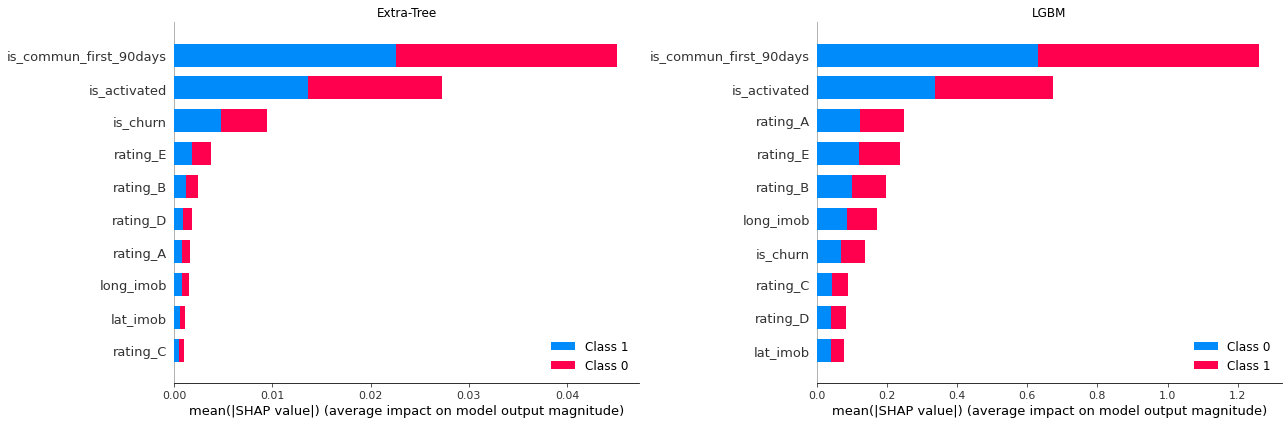

In [21]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
shap_et.summary_plot(plot_type="bar", plot_size=None, show=False)
plt.title("Extra-Tree")

plt.subplot(1,2,2)
shap_lgbm.summary_plot(plot_type="bar", plot_size=None, show=False)
plt.title("LGBM")
plt.tight_layout()
plt.show()

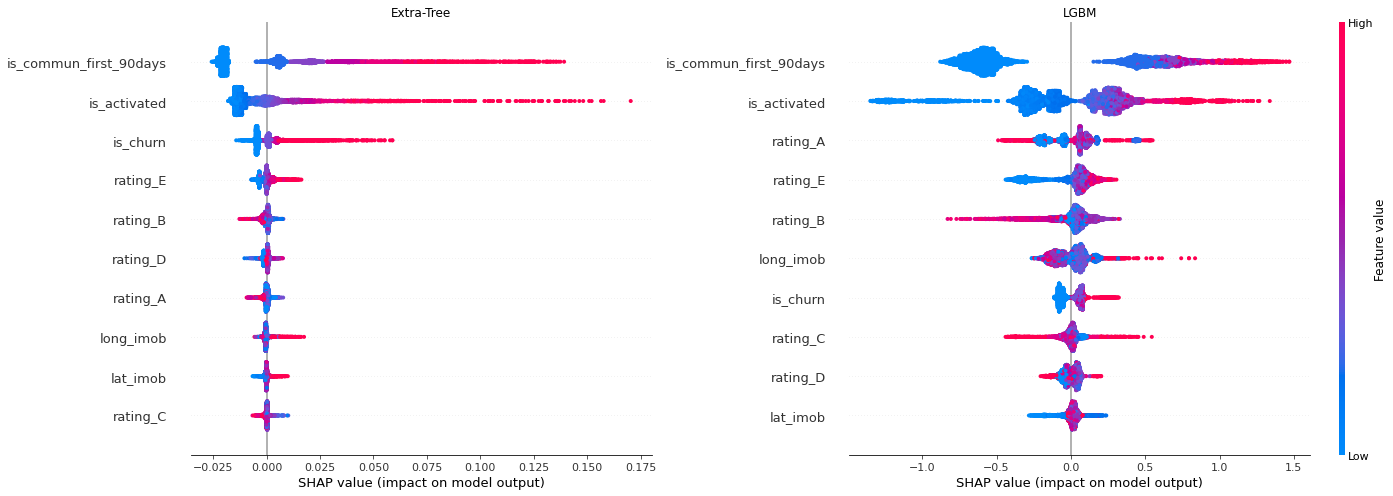

In [22]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
shap_et.summary_plot(plot_size=None, show=False)
plt.title("Extra-Tree")

plt.subplot(1,2,2)
shap_lgbm.summary_plot(plot_size=None, show=False)
plt.title("LGBM")
plt.tight_layout()
plt.show()

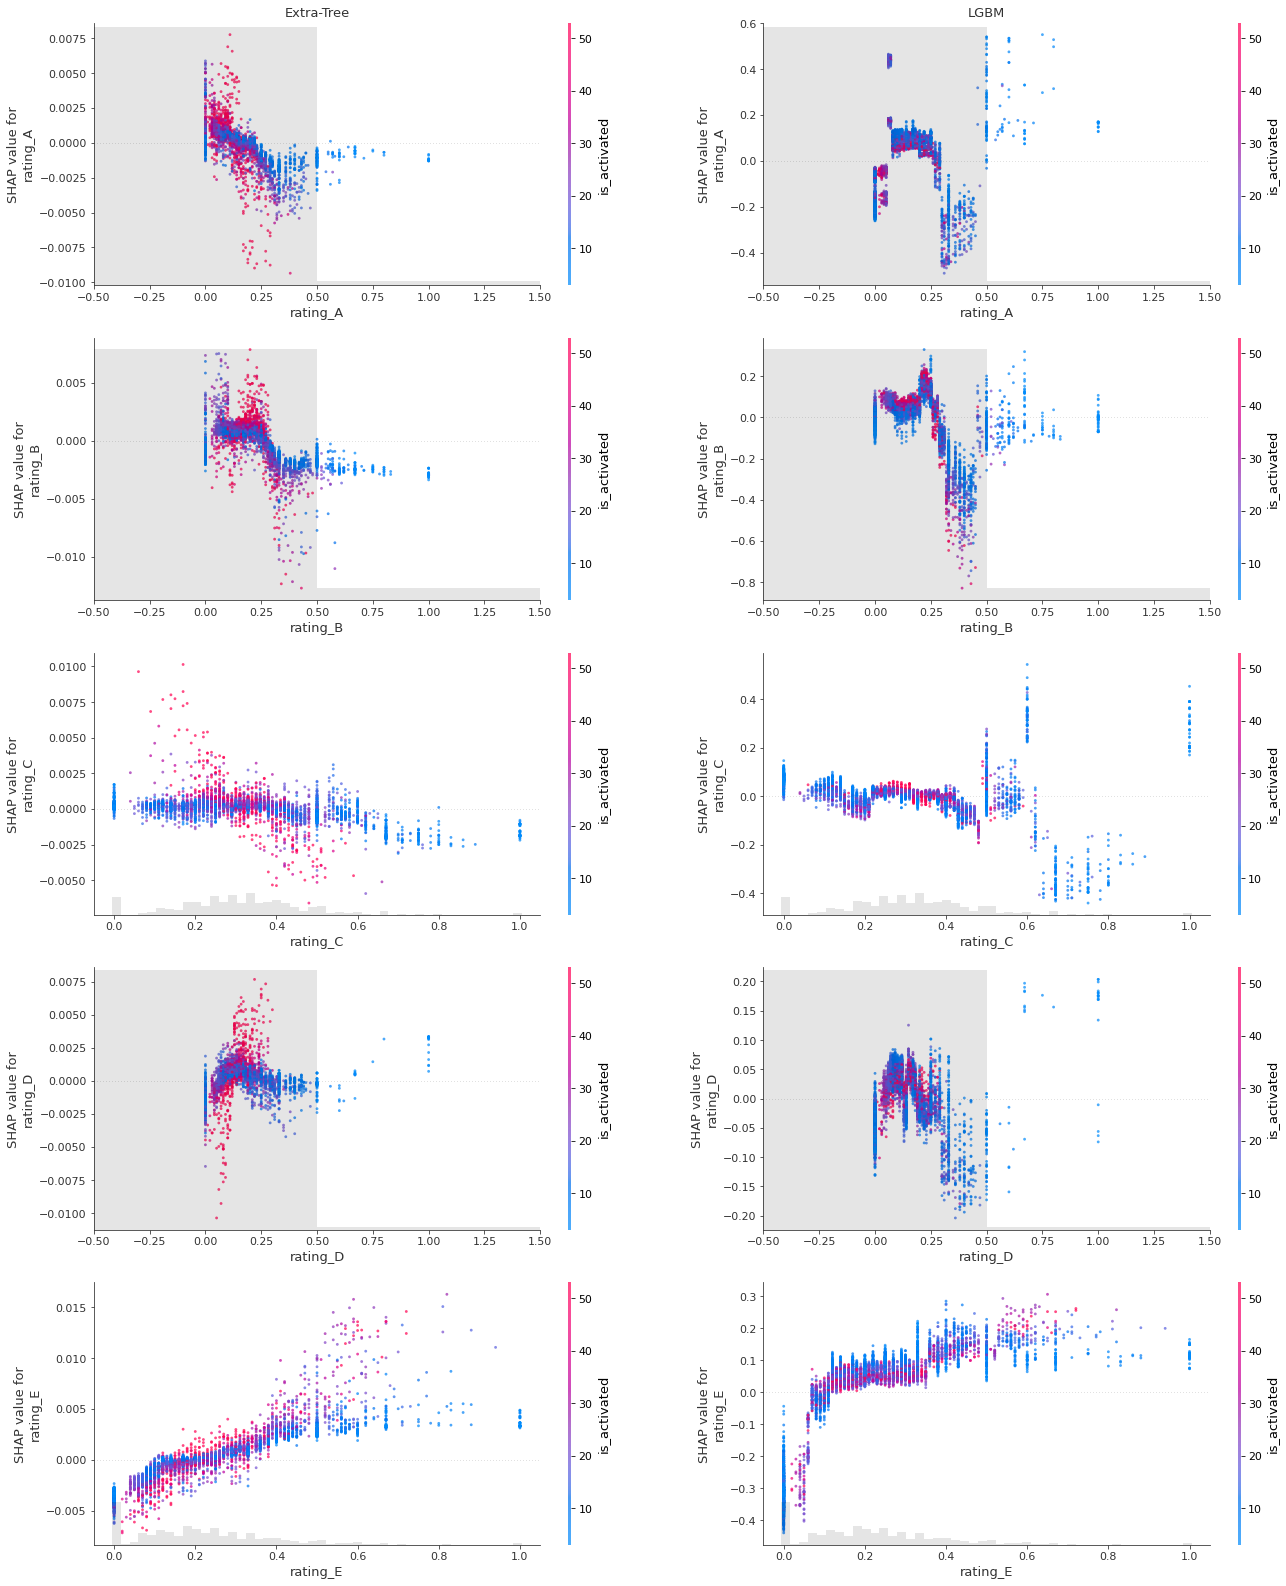

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22,28))
shap_et.scatter_plot(["rating_A", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 0], title="Extra-Tree", show=False)
shap_et.scatter_plot(["rating_B", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 0], show=False)
shap_et.scatter_plot(["rating_C", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 0], show=False)
shap_et.scatter_plot(["rating_D", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 0], show=False)
shap_et.scatter_plot(["rating_E", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 0], show=False)

shap_lgbm.scatter_plot(["rating_A", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 1], title="LGBM", show=False)
shap_lgbm.scatter_plot(["rating_B", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 1], show=False)
shap_lgbm.scatter_plot(["rating_C", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 1], show=False)
shap_lgbm.scatter_plot(["rating_D", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 1], show=False)
shap_lgbm.scatter_plot(["rating_E", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 1], show=False)

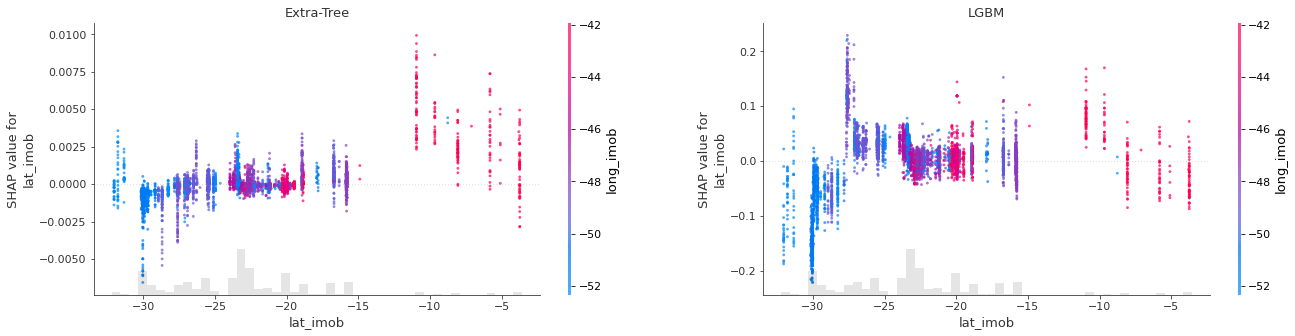

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,5))
shap_et.scatter_plot(["lat_imob", "long_imob"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0], title="Extra-Tree", show=False)
shap_lgbm.scatter_plot(["lat_imob", "long_imob"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1], title="LGBM", show=False)